## Week 3 Project 2:
## CUNY MSDS DATA620 - Web Analytics
---
### Team5: Christopher Estevez, Meaghan Burke, Rickidon Singh,  Ritesh Lohiya, Rose Koh
### 07/02/2018 (due date)
##### python version: 2.7
---

## Degree and Eigenvector centrality


Project 2

    1.Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
    
    2.Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
    
    3.What can you infer about each of the distinct groups?

## 1. Identify Data:

The group identified data at source: http://konect.uni-koblenz.de/networks/moreno_crime.

Original Source: http://moreno.ss.uci.edu/data.html#crime

**DESCRIPTION** One 870×557 two mode valued matrix of individuals by involvement in crime events. One 870×1 vector displaying the sex of each individual.

CRIME two mode, valued
SEX vector reporting sex of each individual.

**BACKGROUND** In the 1990s Rick Rosenfeld and Norm White used police records to collect data on crime in St. Louis. They began with five homicides and recorded the names of all the individuals who had been involved as victims, suspects or witnesses. They then explored the files and recorded all the other crimes in which those same individuals appeared. This snowball process was continued until they had data on 557 crime events. Those events involved 870 participants of which: 569 appeared as victims 682 appeared as suspects 195 appeared as witnesses, and 41 were dual (they were recorded both as victims and suspects in the same crime. Their data appear, then, as an 870 by 557, individual by crime event matrix. Victims are coded as 1, suspects as 2, witnesses as 3 and duals as 4.
In addition Rosenfeld and White recorded the sex of each individual.

## 2. Load & explore the data.

In [83]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('fivethirtyeight')
%matplotlib inline
from networkx.algorithms import bipartite as bi
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#### Load & Merge Files: 
  - **crime_df:** "out.moreno_crime" -- The adjacency matrix of the network in space separated values format, with one edge
  - **person_df:** "ent.moreno_crime.person.name" -- Contains the attribute `name` of entity `person` of the network
  - **person_df['SEX']:** "ent.moreno_crime.person.sex" -- Contains the attribute `sex` of entity `person` of the network
  - **all_data_df:** all metadata merged together 

In [2]:
data_location = "https://raw.githubusercontent.com/silverrainb/web-analytics/master/project2/Data/"

#Loading TSV file
crime_df = pd.read_csv(data_location+"out.moreno_crime_crime", 
                       delim_whitespace=True, header=None, skiprows=[0,1], 
                       names=['PERSON', 'CRIME'])
#Load role
crime_df['ROLE'] = pd.read_csv(data_location+"rel.moreno_crime_crime.person.role", header=None)

#load person information
person_df = pd.read_csv(data_location+"ent.moreno_crime_crime.person.name", header=None,names=['NAME'])

#added index number that matches person crime number
person_df['PERSON'] = person_df.index.values+1

#sex of person
person_df['SEX'] = pd.read_csv(data_location+"ent.moreno_crime_crime.person.sex", header=None)
person_df['SEX'].replace({1: 'M', 0: 'F'}, inplace = True)

#merged data from crime data and person

all_data_df = pd.merge(crime_df,person_df, on=['PERSON'],how='outer')

#### Explore The Data: 
  - Sample the data *.head()*
  - Gather the demographics of each column *.info()*
  - Return a basic graph (G) from Pandas DataFrame containing an edge list. * nx.from_pandas_edgelist()*
  - Print short summary of information for the graph  *nx.info()*
  - Draw the graph G with Matplotlib *nx.draw()*

In [3]:
all_data_df.head()

,PERSON,CRIME,ROLE,NAME,SEX
0,1,1,Suspect,AbelDennis,M
1,1,2,Victim,AbelDennis,M
2,1,3,Victim,AbelDennis,M
3,1,4,Suspect,AbelDennis,M
4,2,5,Victim,AbramsChad,M


In [4]:
role_summary = all_data_df.groupby('ROLE').PERSON.count().reset_index()
role_summary

,ROLE,PERSON
0,Suspect,682
1,Victim,558
2,Victim Suspect,41
3,Witness,195


In [33]:
G = nx.from_pandas_dataframe(all_data_df , 'PERSON','CRIME', edge_attr = ['ROLE','NAME','SEX'],create_using=nx.Graph())

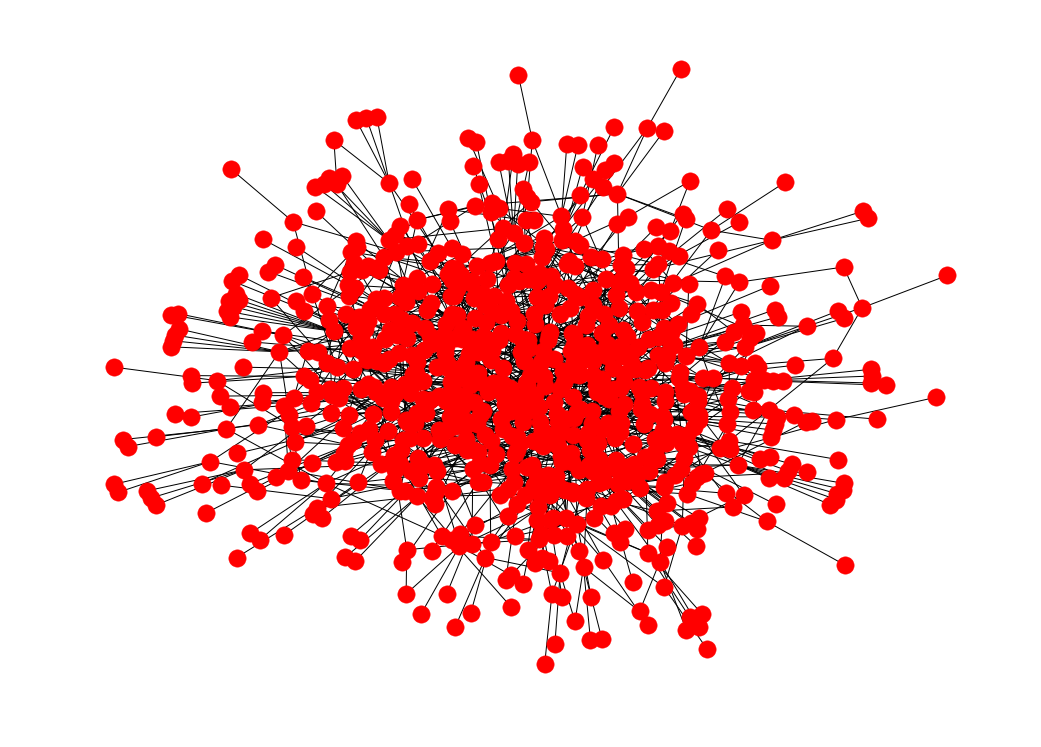

In [34]:
plt.figure(figsize=(14, 10))
nx.draw(G)
plt.show()

## 3. Bipartite Graph
-  **3.1:** Restructure the dataframe to summarize roles and crimes data for each node 
-  **3.2:** Load in all the nodes & edges manually to ensure that the bipartite structure can be formed from the data 
   - Loop through the newly restructured dataframe to add the "person" nodes 
       - Person
       - Sex
       - Role count (suspect, witness, victim, etc.)
       - Crime involvement count
   - Loop through the dataframe for crime node information
   - Add edges between the person and crime nodes 
    - Confirm if the network is structured correctly
- **3.3:** Examine the network
- **3.4** Analyzing network components 



#### 3.1: Restructured Dataframe:

In [6]:
crime_df = all_data_df.copy()
crime_df['TOTAL_ROLE_COUNT'] = crime_df.groupby(['PERSON','ROLE']).CRIME.transform('count')
crime_df['TOTAL_CRIME_COUNT'] = crime_df.groupby(['PERSON']).CRIME.transform('count')
crime_df = crime_df[['NAME', 'CRIME', 'ROLE','TOTAL_ROLE_COUNT','TOTAL_CRIME_COUNT','SEX']]

In [112]:
keys = []
values = []
roles = crime_df['ROLE'].unique().tolist()
for x in roles:
    keys.append(x)
    temp_df = crime_df.loc[crime_df['ROLE'] == x]
    values.append(temp_df['NAME'].unique().tolist())
role_dict = dict(zip(keys, values))

In [7]:
#example row information for network creation
crime_df.iloc[0]

NAME                 AbelDennis
CRIME                         1
ROLE                    Suspect
TOTAL_ROLE_COUNT              2
TOTAL_CRIME_COUNT             4
SEX                           M
Name: 0, dtype: object

#### 3.1: Load Network:

In [8]:
G2 = nx.Graph()
# PERSON NODES
for i in range(len(crime_df)): 
    G2.add_node(crime_df.iloc[i][0],
                ROLE = crime_df.iloc[i][2],
                ROLE_COUNT =crime_df.iloc[i][3],
                CRIME_TOTAL=crime_df.iloc[i][4],
                Sex=crime_df.iloc[i][5],
                bipartite=1)
# CRIME NODES
for i in range(len(crime_df)): 
    G2.add_node(crime_df.iloc[i][1],
                bipartite=0)
# EDGES

for i in range(len(crime_df)):
    G2.add_edge(crime_df.iloc[i][0], crime_df.iloc[i][1], weight=1)

In [9]:
# Checking the stucture of the graph- is it bipartite?
nx.is_bipartite(G2)

True

In [141]:
print(len(G2))
print(len(list(nx.connected_component_subgraphs(G2))))

1379
20


In [149]:
# Top_nodes:PEOPLE
# Bottom_nodes: CRIME
top_nodes = set(n for n,d in G2.nodes(data=True) if d['bipartite']==1)
bottom_nodes = set(G2) - top_nodes

In [11]:
#Sampling of PEOPLE nodes
pd.DataFrame(list(top_nodes)[1:10])

,0
0,SargentDaniel
1,SmothersFreddie
2,CottonJo
3,BurnsDarian
4,MadisonSonny
5,KentonMelba
6,BeckerMax
7,HoltJuanita
8,JamesSara


#### 3.3: Examine the network

In [12]:
print(nx.info(G2))

Name: 
Type: Graph
Number of nodes: 1379
Number of edges: 1476
Average degree:   2.1407


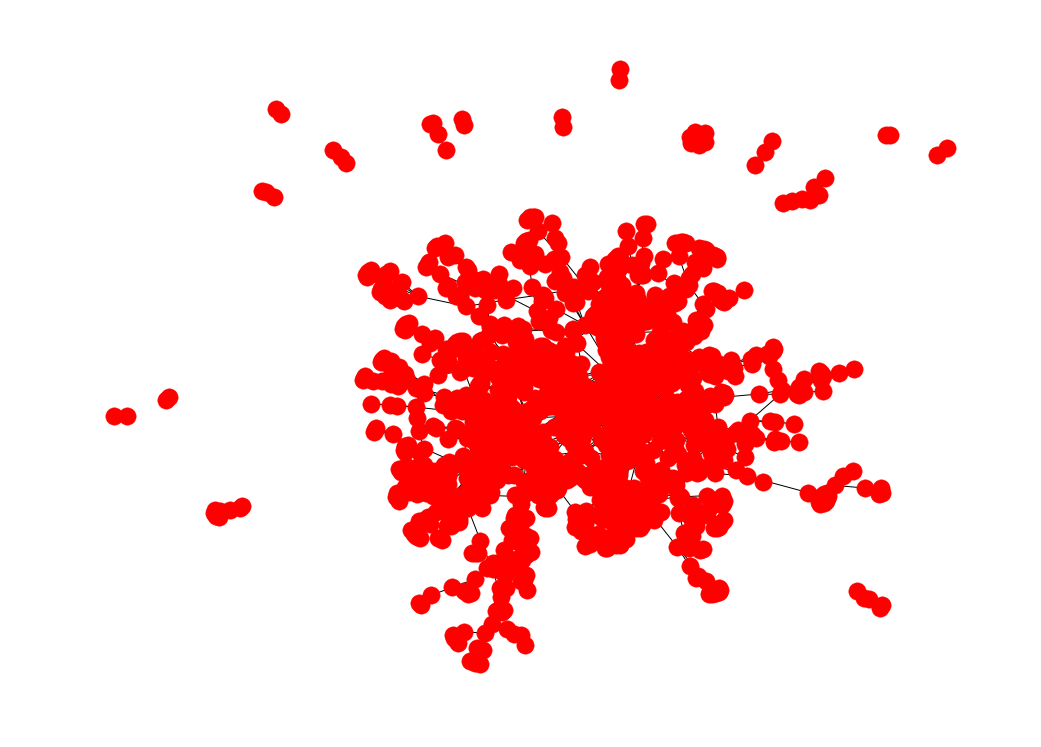

In [32]:
plt.figure(figsize=(14, 10))
nx.draw(G2)
plt.show()

In [164]:
colors

['green',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'green',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'green',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'green',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'green',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'green',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'green',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'green',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 'cyan',
 '

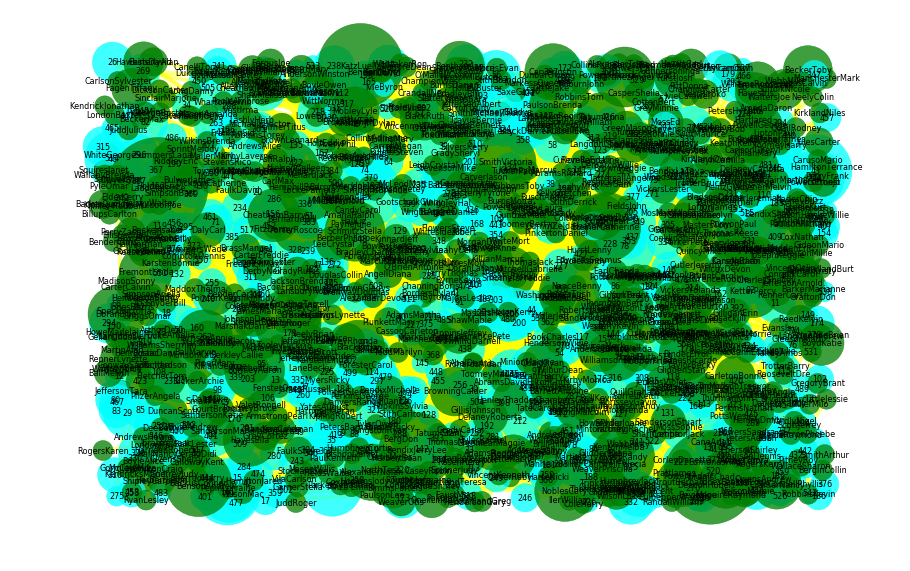

In [38]:
plt.figure(figsize=(14, 10))
pos=nx.random_layout(G2)
g_df =  pd.DataFrame(list(G2.copy().degree()))

colors=[]
for x in g_df[0]:
    if x in top_nodes:
        colors.append('green')
    else:
        colors.append('cyan')
    
# nodes
d = G2.degree()
nx.draw_networkx_nodes(G2,pos, node_color=colors, node_size=[v*400 for v in d.values()], alpha=0.75)
# edges
nx.draw_networkx_edges(G2,pos, width=4,alpha=0.5,edge_color='yellow',style='solid')
nx.draw_networkx_labels(G2,pos, font_size=8, font_family='sans-serif')

plt.axis('off')
plt.show()

In [20]:
##From TEXTBOOK pg. 64
def trim_edges(g, weight = 1):
    # Implements a trimming of the graph edges for the Island Analysis
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight'] > weight:
            g2.add_edge(f,to,edata)
    return g2

def island_method(g, iterations = 5):
    # Iterates through the graph removing edges and returning the number of edges removed and
    #  the trimmed graph
    weights = [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [142]:
top_nodes_nx = nx.bipartite.weighted_projected_graph(G2, top_nodes)
cc = list(nx.connected_component_subgraphs(top_nodes_nx ))[0]

In [143]:
values = [['Threshold','Number of People', 'Connection Number']]
islands = island_method(cc, iterations = 4)
for x in islands:
    threshold =x[0]
    num_people = len(x[1])
    connections = len(list(nx.connected_component_subgraphs(x[1])))
    temp_list = [threshold, num_people, connections]
    values.append(temp_list)
    
headers = values.pop(0)
islan_df = pd.DataFrame(values,columns = headers)

In [144]:
islan_df

,Threshold,Number of People,Connection Number
0,1,89,27
1,2,28,12
2,3,15,7
3,4,6,3


In [188]:
len(island_plot.degree(top_nodes).keys())

89

In [187]:
len(color)

89

AttributeError: 'list' object has no attribute 'shape'

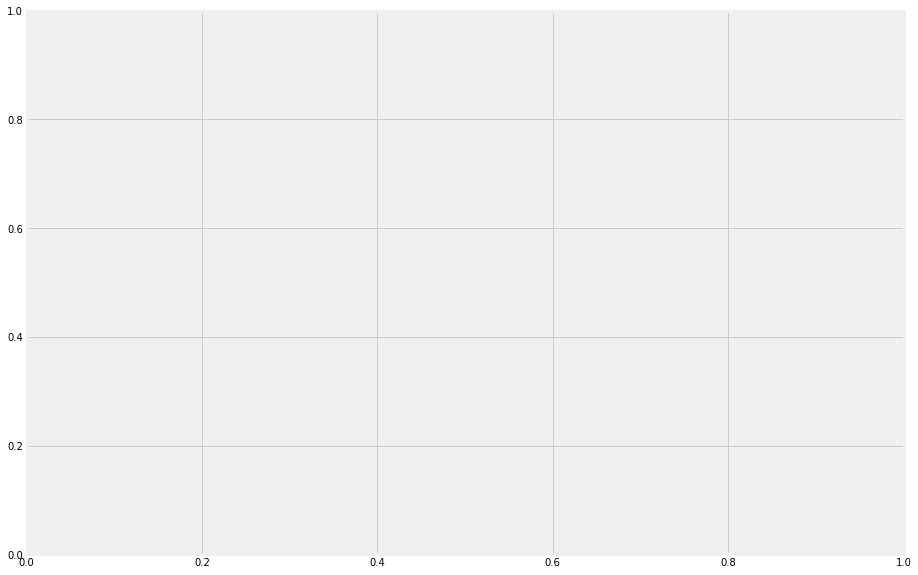

In [184]:
## Plotting created by the island analysis## Plott 
plt.figure(figsize=(14, 10))
island_plot = trim_edges(cc, 1)
pos=nx.random_layout(island_plot)

color=[]
for x in island_plot.degree(top_nodes).keys():
    if x in role_dict ['Suspect']:
        color.append('lightred')
    elif x in role_dict['Victim']:
        color.append('springgreen')
    else:
        color.append('turquoise')
d_island =island_plot.degree()

nx.draw_networkx_nodes(island_plot,pos, node_size=[v*400 for v in d_island.values()], alpha=0.75, node_color =color)
plt.axis('off')
plt.show()

In [153]:
color

['springgreen', 'lightred', 'springgreen', 'lightred', 'lightred', 'lightred']

In [56]:
roles 

['Suspect', 'Victim', 'Witness', 'Victim Suspect']

In [64]:
#G.edges(data=True)


False

## Sources

http://www.datasciencemadesimple.com/join-merge-data-frames-pandas-python/